# 3. Radiative backpropagation pipeline

## Overview

Hello RB pipeline!

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Use Radiative Backpropagation Python integrators</li>
  <li>Optimize cool stuff</li>
</ul>
    
</div>


### Step 1 - setup

We start by importing an AD variant of Mitsuba. We then load and traverse the scene to be able to access its parameters later.

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
from matplotlib import pyplot as plt
import enoki as ek 
import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

In [3]:
from mitsuba.core import xml, Color3f
from mitsuba.python.util import traverse, convert_to_bitmap

def show_image(img, title):
    plt.imshow(convert_to_bitmap(img)); plt.axis('off'); plt.title(title);

scene = xml.load_file('../scenes/cbox.xml', res=128, spp=16)

max_depth = 4
rb_integrator = xml.load_dict({
    'type': 'rb',
    'max_depth': max_depth
})
path_integrator = xml.load_dict({
    'type': 'path',
    'max_depth': max_depth
})

2021-09-13 16:25:41 INFO main [xml.cpp:1261] Loading XML file "../scenes/cbox.xml" ..

2021-09-13 16:25:41 INFO main [xml.cpp:1262] Using variant "cuda_ad_rgb"

2021-09-13 16:25:41 INFO main [Scene] Building scene in OptiX ..

2021-09-13 16:25:41 INFO main [Scene] OptiX ready. (took 26ms)

### Step 2 - primal rendering

We first perform a primal rendering step without AD

2021-09-13 16:25:42 INFO main [SamplingIntegrator] Start rendering...

2021-09-13 16:25:43 INFO main [SamplingIntegrator] Computation graph recorded. (took 27ms)

2021-09-13 16:25:43 INFO main [SamplingIntegrator] Code generation finished. (took 577ms)

2021-09-13 16:25:43 INFO main [SamplingIntegrator] Rendering finished. (took 608ms)

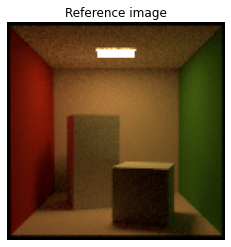

In [4]:
integrator = scene.integrator()
image_ref = rb_integrator.render(scene, seed=0, spp=128)
show_image(image_ref, 'Reference image')

2021-09-13 16:25:44 INFO main [SamplingIntegrator] Start rendering...

2021-09-13 16:25:44 INFO main [SamplingIntegrator] Computation graph recorded. (took 13ms)

2021-09-13 16:25:45 INFO main [SamplingIntegrator] Code generation finished. (took 544ms)

2021-09-13 16:25:45 INFO main [SamplingIntegrator] Rendering finished. (took 612ms)

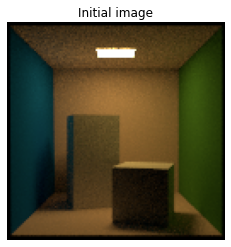

In [5]:
params = traverse(scene)

# Update scene parameter
key = 'redwall.bsdf.reflectance.value'
params.keep([key])
param_ref = Color3f(params[key])
params[key] = Color3f(0.01, 0.2, 0.9)
params.update()

# Render initial image
scene.sensors()[0].sampler().seed(0)
image = rb_integrator.render(scene, seed=0, spp=128)
show_image(image, 'Initial image')

### Step 3 - Loss image

We need to define an objective function and compute the gradients of the result of that function with respect to the output image of the primal rendering step. This will give us a *loss image* where every pixel is the gradient of the corresponding primal pixel value w.r.t. the objective function.

In this simple tutorial, the objective function will be the MSE with regards to the reference image.

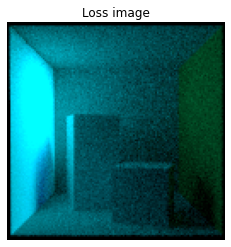

In [6]:
def compute_image_loss(image, obj_func):  
    ek.enable_grad(image)
    ob_val = obj_func(image)
    ek.backward(ob_val)
    image_loss = ek.grad(image)
    ek.set_grad(image, 0.0)
    return image_loss
    
def MSE(img):
    return ek.hsum_async(ek.sqr(img - image_ref)) / len(img)
    
image_adj = compute_image_loss(image, MSE)

show_image(image_adj * 1e6, 'Loss image')

### Step 4 - Radiative Backpropagation

The image loss needs to be backpropagated throught the light transport simulation to the scene parameters.
Instead of relying on automatic differentiation, we will this time use a Radiative Backpropagation integrator to propagate the image loss gradient values.

In [7]:
rb_integrator.render_backward(scene, params, image_adj, seed=0)
grad_backward = ek.grad(params[key])

### Forward AD rendering with regular path tracer

2021-09-13 16:26:08 INFO main [SamplingIntegrator] Start rendering...

2021-09-13 16:26:09 INFO main [SamplingIntegrator] Rendering finished. (took 1.286s)

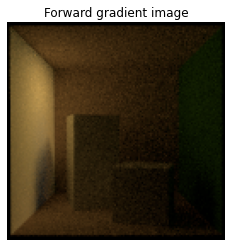

In [9]:
ek.set_grad(params[key], 0.0)
ek.enable_grad(params[key])
ek.set_flag(ek.JitFlag.LoopRecord, False)
image = path_integrator.render(scene, seed=0, spp=128)
ek.forward(params[key])

grad = ek.grad(image)

show_image(grad, "Forward gradient image")

### *Reference API*

- [<code>mitsuba.core.xml.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.xml.load_file)